# Car-Identifier for PyTorch

Description: A Convolutional Neural-Network that uses a tensor to resize images and augment the result. Images are resized to 64 by 64, and then passed through the model. The CNN learns from the test and validation datasets and returns a couple of images illustrating benchmarking data via matplotlib, and the result of a couple of predictions of random images from the image datasets. At the time of the creation of this notebook, the accuracy of the Neural-Net stands at approximately `88%`.



Author: James Anthony Ortiz
Last-Edit: 10/26/2019 
Course: CEN4020 - Software Engineering II


## Section I: Adding Libraries

In order to permit the full functionality of the CNN, we will need to integrate a couple of external libraries into out program, mainly the following:

+ OpenCV
+ torch (via PyTorch)
+ matplotlib
+ PIL
+ numpy


## Section II: Transforming the Images & Creating the Dataset

In PyTorch, `transforms` performs multiple modifications on the images once the tensor is created. For this to work successfully, the pictures and their noralizations have to be calculated according to their size. Then a dataset is created for training purpose using the `datasets.ImageFolder()` function. In the first argument, the direct path of the DataSet is placed, each of the classes that you would like to use alongside with your program. For example in this application there is a collection of car pictures as well as pictures that are not of cars. 

In [2]:
#Importing libraries to be used in the program:

import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision
import torchvision.datasets as datasets
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [3]:
#Transformation for image removed: transforms.RandomHorizontalFlip()
transform_ori = transforms.Compose([transforms.RandomResizedCrop(64),          #create 64x64 image
                                    #flipping the image horizontally
                                    transforms.ToTensor(),                     #convert the image to a Tensor
transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  #normalize the image




#Load our dataset
train_dataset = datasets.ImageFolder(root = '/home/james/Desktop/carNonCarImageset/trainingSet',
                                     transform = transform_ori)

test_dataset = datasets.ImageFolder(root = '/home/james/Desktop/carNonCarImageset/testSet',
                                    transform = transform_ori)


#Make the dataset iterable
batch_size = 32
train_load = torch.utils.data.DataLoader(dataset = train_dataset, 
                                         batch_size = batch_size,
                                         shuffle = True) 

In [4]:
test_load = torch.utils.data.DataLoader(dataset = test_dataset, 
                                         batch_size = batch_size,
                                        shuffle = False)
#Make Classes
classes = ('car', 'nonCar')

#create an iterator for train_loader
# get random training images
data_iterator = iter(train_load)
images, labels = data_iterator.next()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


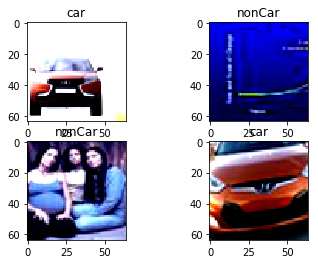

There are 669 images in the training set
There are 199 images in the test set


In [5]:
#plot 4 images to visualize the data
rows = 2
columns = 2
fig=plt.figure()
for i in range(4):
   fig.add_subplot(rows, columns, i+1)
   plt.title(classes[labels[i]])
   img = images[i] / 2 + 0.5     # this is for unnormalize the image
   npimg = img.numpy()
   img = torchvision.transforms.ToPILImage()(img)
   plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()
                                         


# get some random training images
dataiter = iter(train_load)
images, labels = dataiter.next()


# show images
#imshow(torchvision.utils.make_grid(images))

print('There are {} images in the training set'.format(len(train_dataset)))
print('There are {} images in the test set'.format(len(test_dataset)))

## Section III: Creating the Convolutional-Neural-Network

The PyTorch website provides a good backdrop to understanding the functionality, as well as the basic structure of how a CNN should be formatted. For more information on this please visit the website [here].

[here]: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [9]:
#---------------Class Definition: ---------------------------#

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3,stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(8)            #Batch normalization
        self.relu = nn.ReLU()                          #RELU Activation
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)    #Maxpooling reduces the size by kernel size. 64/2 = 32
        
        self.cnn2 = nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)    #Size now is 32/2 = 16
        
        #Flatten the feature maps. You have 32 feature mapsfrom cnn2. Each of the feature is of size 16x16 --> 32*16*16 = 8192
        self.fc1 = nn.Linear(in_features=8192, out_features=4000)   #Flattened image is fed into linear NN and reduced to half size
        self.droput = nn.Dropout(p=0.5)                    #Dropout used to reduce overfitting
        self.fc2 = nn.Linear(in_features=4000, out_features=2000)
        self.droput = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(in_features=2000, out_features=500)
        self.droput = nn.Dropout(p=0.5)
        self.fc4 = nn.Linear(in_features=500, out_features=50)
        self.droput = nn.Dropout(p=0.5)
        self.fc5 = nn.Linear(in_features=50, out_features=2)    #Since there were so many features, I decided to use 45 layers to get output layers. You can increase the kernels in Maxpooling to reduce image further and reduce number of hidden linear layers.
       
        
    def forward(self,x):
        out = self.cnn1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)
        out = self.maxpool1(out)
        out = self.cnn2(out)
        out = self.batchnorm2(out)
        out = self.relu(out)
        out = self.maxpool2(out)
        #Flattening is done here with .view() -> (batch_size, 32*16*16) = (100, 8192)
        out = out.view(-1,8192)   #-1 will automatically update the batchsize as 100; 8192 flattens 32,16,16
        #Then we forward through our fully connected layer 
        out = self.fc1(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc3(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc4(out)
        out = self.relu(out)
        out = self.droput(out)
        out = self.fc5(out)
        return out

model = CNN()
CUDA = torch.cuda.is_available()
if CUDA:
    model = model.cuda()    
loss_fn = nn.CrossEntropyLoss()        
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)

#--------------------------------------

## Section IV: Training The CNN

In this CNN we use a function to let the CNN backpropagate through a set of Epochs (in this case, 55 of them). To allow for the calculation of accuracy during the training 2 sets of lists are declared for training and set accuracy. For further optimization, CUDA was included in the function definition if it is available.

In [10]:

#Training the CNN
import time

num_epochs = 55 #55

#Define the lists to store the results of loss and accuracy
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

#Training
for epoch in range(num_epochs): 
    #Reset these below variables to 0 at the begining of every epoch
    start = time.time()
    correct = 0
    iterations = 0
    iter_loss = 0.0
    
    model.train()                   # Put the network into training mode
    
    for i, (inputs, labels) in enumerate(train_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        # If we have GPU, shift the data to GPU
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()            # Clear off the gradient in (w = w - gradient)
        outputs = model(inputs)         
        loss = loss_fn(outputs, labels)  
        iter_loss += loss.data          # Accumulate the loss
        loss.backward()                 # Backpropagation 
        optimizer.step()                # Update the weights
        
        # Record the correct predictions for training data 
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        iterations += 1
    
    # Record the training loss
    train_loss.append(iter_loss/iterations)
    # Record the training accuracy
    train_accuracy.append((100 * correct / len(train_dataset)))
   
    #Testing
    loss = 0.0
    correct = 0
    iterations = 0

    model.eval()                    # Put the network into evaluation mode
    
    for i, (inputs, labels) in enumerate(test_load):
        
        # Convert torch tensor to Variable
        inputs = Variable(inputs)
        labels = Variable(labels)
        
        CUDA = torch.cuda.is_available()
        if CUDA:
            inputs = inputs.cuda()
            labels = labels.cuda()
        
        outputs = model(inputs)     
        loss = loss_fn(outputs, labels) # Calculate the loss
        loss += loss.data
        # Record the correct predictions for training data
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum()
        
        iterations += 1

    # Record the Testing loss
    test_loss.append(loss/iterations)
    # Record the Testing accuracy
    test_accuracy.append((100 * correct / len(test_dataset)))
    stop = time.time()
    
    print ('Epoch {}/{}, Training Loss: {:.3f}, Training Accuracy: {:.3f}, Testing Loss: {:.3f}, Testing Acc: {:.3f}, Time: {}s'
           .format(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], test_loss[-1], test_accuracy[-1], stop-start))

Epoch 1/55, Training Loss: 0.691, Training Accuracy: 53.000, Testing Loss: 0.193, Testing Acc: 50.000, Time: 8.134374856948853s
Epoch 2/55, Training Loss: 0.690, Training Accuracy: 54.000, Testing Loss: 0.188, Testing Acc: 50.000, Time: 7.615638494491577s
Epoch 3/55, Training Loss: 0.686, Training Accuracy: 56.000, Testing Loss: 0.184, Testing Acc: 50.000, Time: 8.239656448364258s
Epoch 4/55, Training Loss: 0.685, Training Accuracy: 55.000, Testing Loss: 0.179, Testing Acc: 50.000, Time: 8.143970012664795s
Epoch 5/55, Training Loss: 0.683, Training Accuracy: 55.000, Testing Loss: 0.178, Testing Acc: 50.000, Time: 7.465709447860718s
Epoch 6/55, Training Loss: 0.682, Training Accuracy: 55.000, Testing Loss: 0.174, Testing Acc: 50.000, Time: 7.55156946182251s
Epoch 7/55, Training Loss: 0.679, Training Accuracy: 55.000, Testing Loss: 0.168, Testing Acc: 50.000, Time: 8.720267295837402s
Epoch 8/55, Training Loss: 0.674, Training Accuracy: 56.000, Testing Loss: 0.167, Testing Acc: 50.000, Ti

## Section V: Plotting the Results to a Graph

In this section, we will continue to use matplotlib, and numpy to help describe if the images are either cars or not. Particularly this portion of the source code tests for `loss` and `accuracy`. Finally, we will be plotting two examples from out image dataset to determine if there is really an improvement in the CNN's learning ability.

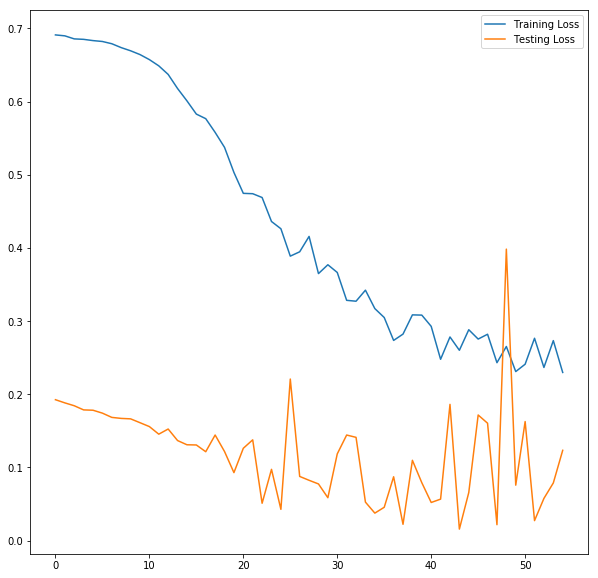

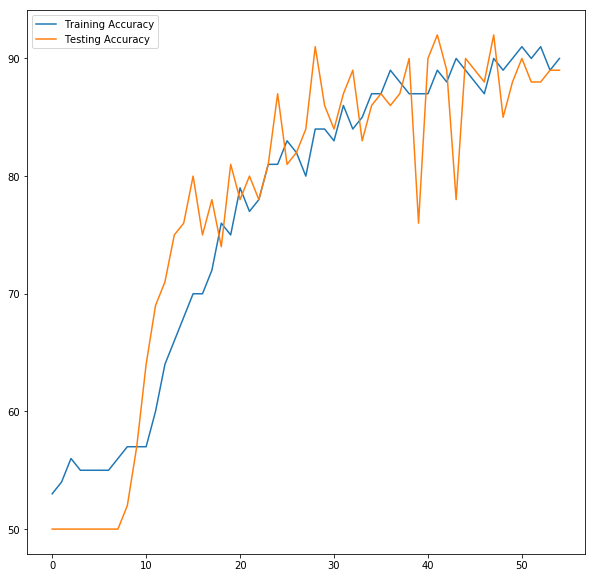

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted:    car   car   car   car


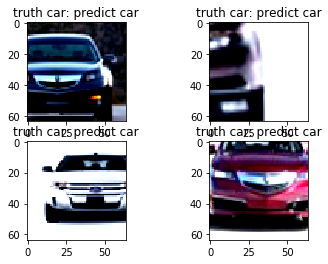

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:

#---------------------Graphing Loss/Accuracy: ----------------------------#
# Loss
f = plt.figure(figsize=(10, 10))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.legend()
plt.show()

# Accuracy
f = plt.figure(figsize=(10, 10))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(test_accuracy, label='Testing Accuracy')
plt.legend()
plt.show()

#make an iterator from test_loader
#Get a batch of training images
test_iterator = iter(test_load)
images, labels = test_iterator.next()

results = model(images)
_, predicted = torch.max(results, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

fig2 = plt.figure()
for i in range(4):
   fig2.add_subplot(rows, columns, i+1)
   plt.title('truth ' + classes[labels[i]] + ': predict ' + classes[predicted[i]])
   img = images[i] / 2 + 0.5     # this is to unnormalize the image
   npimg = img.numpy()
   img = torchvision.transforms.ToPILImage()(img)
   plt.imshow(np.transpose(npimg, (1,2,0)))
plt.show()


#Run this if you want to save the model
torch.save(model.state_dict(),'Cars-NotCars.pth')

#Run this if you want to load the model
model.load_state_dict(torch.load('Cars-NotCars.pth'))